# Kaggle - Bike Sharing Demand - Prediction

### Important
* **For forecasting only use data from time up to the forecast period**
* Cost function is RMSE of log(1 + count), so it makes sense to optimise to predict log(1 + count).

### Questions
* Casual and registered users - should they be treated as separate data sets?

### Conclusions from data exploration
1. It seems to be a good idea to train separate models for registered and casual rentals, as they seem to respond differently to days off, weather etc.
1. There is only one (hour) record of weather = 4 (the most extreme), so this should be relabeled as 3 (effectively merging 3 and 4) or discarded to avoid problems
1. There are only 311 recorded hours (about 13 days) of holiday rentals over 2 years. In addition, we can only use past data for prediction at any point, so holiday may be a confusing feature.

In [1]:
from __future__ import division
import six
from functools import partial
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from dateutil.parser import parse
import warnings
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, ElasticNetCV, RandomizedLasso
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
%matplotlib inline

In [2]:
def parse_features(filename):
    # Parse data from csv to np arrays
    
    features = {}

    datetime = np.loadtxt(filename, 
                          dtype=dt.datetime, 
                          converters={0: parse}, 
                          delimiter=',', 
                          skiprows=1, 
                          usecols=(0,))

    features['year'] = np.asarray(list(d.year for d in datetime))
    features['month'] = np.asarray(list(d.month for d in datetime))
    features['day'] = np.asarray(list(d.day for d in datetime))
    features['wday'] = np.asarray(list(d.isoweekday() for d in datetime))
    features['hour'] = np.asarray(list(d.hour for d in datetime))

    start_year = features['year'][0]
    features['month_since_start'] = features['month'] + (features['year'] - start_year) * 12
    
    features['timestamp'] = np.loadtxt(filename, 
                                       dtype=str, 
                                       delimiter=',', 
                                       skiprows=1, 
                                       usecols=(0,))
    
    other = np.loadtxt(filename, 
                       delimiter=',', 
                       skiprows=1, 
                       usecols=range(1, 9))

    features['season'] = other[:, 0].astype(np.int64)
    features['season_since_start'] = features['season'] + (features['year'] - start_year) * 4

    features['holiday'] = other[:, 1].astype(np.int64)
    features['workingday'] = other[:, 2].astype(np.int64)

    features['weather'] = other[:, 3].astype(np.int64)
    features['temp'] = other[:, 4]
    features['atemp'] = other[:, 5]
    features['humidity'] = other[:, 6]
    features['windspeed'] = other[:, 7]

    return features


def parse_targets(filename):
    
    targets = np.loadtxt(filename, 
                         delimiter=',', 
                         skiprows=1, 
                         usecols=range(9, 12))
    
    casual = targets[:, 0]
    registered = targets[:, 1]
    count = targets[:, 2]

    casual_l1p = np.log1p(casual)
    registered_l1p = np.log1p(registered)
    count_l1p = np.log1p(count)
    
    return casual_l1p, registered_l1p, count_l1p

In [3]:
train_filename = 'data/train.csv'
train_features = parse_features(train_filename)
train_casual_l1p, train_registered_l1p, train_count_l1p = parse_targets(train_filename)

## Validation and testing design

### Testing 
Kaggle takes care of testing the complete model. The task is to use the first 19 days of the month (and any past data before that) to predict the remaining 9 to 11 days.
**Remember that only data from before days for which predictions are made can be used for training and prediction.** (Someone on the forum suggested running a loop over months to take care of this.)

### Validation
Validation has to be done in development. The first idea is to use the first 10 days of the month (and any data before that) for training and the remaining 9 days for validation. This should give us a similar time horizon in validation to the one in testing.


In [4]:
def validate(models, features, targets, n_train_days=10, debug=False):
    # The parameters models and targets_train must be lists of length 1 or 2 (must be the same for both).
    # If their length is 1, a single model will be built. If their length is 2, then two separate models
    # will be built, with the first regressor in models fit to predict the first vector in targets and 
    # the second regressor in models fit to predict the second vector in targets. In the case of two
    # models, the final prediction is generated by applying the inverse of log(1 + x), adding them 
    # together and applying log(1 + x) to the sum.
 
    scores = []
    
    for this_month_since_start in np.unique(features['month_since_start']):
        
        # Identify training data from previous months, from this month and validation
        # data from this month
        is_prev_months_fit = (features['month_since_start'] < this_month_since_start)
        is_this_month_fit = np.logical_and(features['month_since_start'] == this_month_since_start,
                                           features['day'] <= n_train_days)
        
        is_fit = np.logical_or(is_prev_months_fit, is_this_month_fit)
        
        is_val = np.logical_and(features['month_since_start'] == this_month_since_start,
                                features['day'] > n_train_days)
        
        features_fit = {}
        features_val = {}
        
        for k in features:
            features_fit[k] = features[k][is_fit]
            features_val[k] = features[k][is_val]    
        
        if (len(models) == 2) and (len(targets) == 2):

            # The targets are log(1 + x) so one has to be careful combining them
            # if y = log(1 + x) then exp(y) = 1 + x, i.e. x = exp(y) - 1
            target_total = np.log1p(np.exp(targets[0]) - 1 + np.exp(targets[1]) - 1)
            
            # Train the models on past data
            models[0].fit(features_fit, targets[0][is_fit])
            models[1].fit(features_fit, targets[1][is_fit])
        
            # Validate on this month's end
            target0_val_pred = models[0].predict(features_val)
            target1_val_pred = models[1].predict(features_val)

            # The targets are log(1 + x) so one has to be careful combining them
            # if y = log(1 + x) then exp(y) = 1 + x, i.e. x = exp(y) - 1
            target_total_val_pred = np.log1p(np.exp(target0_val_pred) - 1 + np.exp(target1_val_pred) - 1)
            
        elif (len(models) == 1) and (len(targets) == 1):
            
            target_total = targets[0]
            
            # Train the model on past data
            models[0].fit(features_fit, target_total[is_fit])
        
            # Validate on this month's end
            target_total_val_pred = models[0].predict(features_val)
        
        else:
            raise ValueError("The parameters 'models' and 'targets' must have the same length.")
        
        score = np.sqrt(np.mean((target_total_val_pred - target_total[is_val])**2))
        scores.append(score)
        
        if debug:
            print('  Month ' + str(this_month_since_start) + 
                  ', score: ' + str(score) +
                  ', n_fit = ' + str(np.sum(is_fit)) +
                  ', n_val = ' + str(np.sum(is_val)))
    
    return np.asarray(scores)


In [5]:
def features_to_matrix(*args):
    # Construct a feature matrix from features given as 1d vectors
    
    add_axis1 = partial(np.expand_dims, axis=1)
    X = np.concatenate(map(add_axis1, args), axis=1)
    return X

## Models

### Simple model that looks only at current hour's data for prediction but trains on as much data as possible
This model can have a large training set, looking at all the data that is in the past relative to the period for which prediction is made.

In [6]:
class ModelSimple:
    # Prediction looking only at the data from the current hour
    # Trained on all data passed to it

    def __init__(self, skl_reg):
        # Provide your own regression from scikit-learn (or compatible)
        self.skl_reg = skl_reg
        
    def my_features_to_matrix(self, features):
        X = features_to_matrix(features['wday'], 
                               features['hour'],
                               features['holiday'],
                               features['workingday'],
                               features['weather'],
                               features['temp'],
                               features['atemp'],
                               features['humidity'],
                               features['windspeed'],
                               features['month_since_start'],
                              )
        
        return X

    def fit(self, features, target):
        X = self.my_features_to_matrix(features)
        self.skl_reg.fit(X, target)
    
    def predict(self, features):
        X = self.my_features_to_matrix(features)
        return self.skl_reg.predict(X)

In [7]:
np.random.seed(42)
poly_feat = PolynomialFeatures(degree=2, include_bias=False)

reg = RandomForestRegressor(n_estimators=200, n_jobs=-1)
#reg = RidgeCV(alphas=np.logspace(-6, 6, num=100, base=10.0), normalize=True)
#reg = ElasticNetCV(l1_ratio=(.1, .5, .7, .9, .95, .99, 1), n_alphas=100, normalize=True, max_iter=10000)

#skl_pipeline = Pipeline([('poly_feat', poly_feat), ('reg', reg)])
skl_pipeline = Pipeline([('reg', reg)])

model_simple = ModelSimple(skl_pipeline)
val_scores_simple = validate([model_simple], train_features, [train_count_l1p])

Score = 0.3401


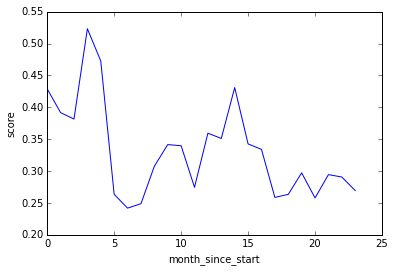

In [8]:
plt.plot(val_scores_simple)
plt.xlabel('month_since_start')
plt.ylabel('score')
print('Score = {:.4f}'.format(np.sqrt(np.mean(val_scores_simple**2))))

### Registered and casual rentals model
This model predicts registered and casual rentals separately and adds the results together. It consists simply of applying two other models in parallel. Since the simple models worked best so far, we use this one.

#### First, see how well we can predict registered rentals.

In [9]:
np.random.seed(42)

reg = RandomForestRegressor(n_estimators=200, n_jobs=-1)

# NOTE: if you changed ModelSimple, the results below may be unexpected
model_registered = ModelSimple(reg)
val_scores_registered = validate([model_registered], train_features, [train_registered_l1p])

Score = 0.3234


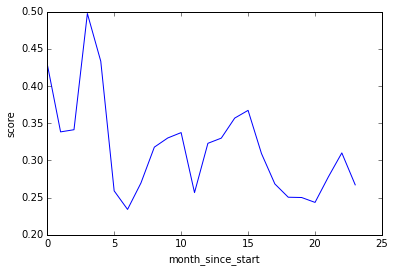

In [10]:
plt.plot(val_scores_registered)
plt.xlabel('month_since_start')
plt.ylabel('score')
print('Score = {:.4f}'.format(np.sqrt(np.mean(val_scores_registered**2))))

#### Second, see how well we can predict casual rentals

In [11]:
np.random.seed(42)

reg = RandomForestRegressor(n_estimators=200, n_jobs=-1)

# NOTE: if you changed ModelSimple, the results below may be unexpected
model_casual = ModelSimple(reg)
val_scores_casual = validate([model_casual], train_features, [train_casual_l1p])

Score = 0.5719


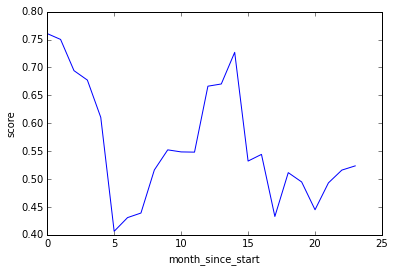

In [12]:
plt.plot(val_scores_casual)
plt.xlabel('month_since_start')
plt.ylabel('score')
print('Score = {:.4f}'.format(np.sqrt(np.mean(val_scores_casual**2))))

#### Third, we combine the two models in parallel

In [13]:
np.random.seed(42)

# NOTE: if you changed ModelSimple, the results below may be unexpected
model_regcas_registered = ModelSimple(RandomForestRegressor(n_estimators=200, n_jobs=-1))
model_regcas_casual = ModelSimple(RandomForestRegressor(n_estimators=200, n_jobs=-1))

val_scores_regcas = validate([model_regcas_registered, model_regcas_casual], train_features, [train_registered_l1p, train_casual_l1p])

Score = 0.3323


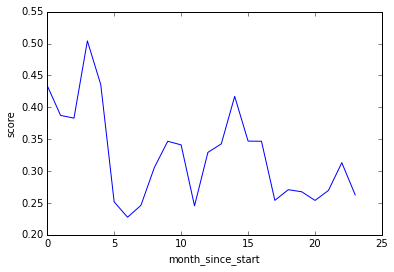

In [14]:
plt.plot(val_scores_regcas)
plt.xlabel('month_since_start')
plt.ylabel('score')
print('Score = {:.4f}'.format(np.sqrt(np.mean(val_scores_regcas**2))))

This model gives better average validation score than the simple model applied directly to total rentals.

## Generating the submission file

To generate predictions for Kaggle, test data has to be read and parsed.

In [15]:
test_filename = 'data/test.csv'
test_features = parse_features(test_filename)

Now, another loop is required to build a sequence of models for full training data available for successive months and generate predictions. 

In [16]:
def generate_predictions(models, features_train, targets_train, features_test, debug=False):
    # The parameters models and targets_train must be lists of length 1 or 2 (must be the same for both).
    # If their length is 1, a single model will be built. If their length is 2, then two separate models
    # will be built, with the first regressor in models fit to predict the first vector in targets and 
    # the second regressor in models fit to predict the second vector in targets. In the case of two
    # models, the final prediction is generated by applying the inverse of log(1 + x) and adding them 
    # together.
    
    timestamps_predictions = []
    
    for this_month_since_start in np.unique(features_test['month_since_start']):
        
        this_fit = (features_train['month_since_start'] <= this_month_since_start)
        this_test = (features_test['month_since_start'] == this_month_since_start)
        
        features_fit = {}
        features_this_test = {}
        
        for k in features_train:
            features_fit[k] = features_train[k][this_fit]
        
        for k in features_test:
            features_this_test[k] = features_test[k][this_test]
            
        if (len(models) == 2) and (len(targets_train) == 2):

            models[0].fit(features_fit, targets_train[0][this_fit])
            models[1].fit(features_fit, targets_train[1][this_fit])
        
            target0_test_pred = models[0].predict(features_this_test)
            target1_test_pred = models[1].predict(features_this_test)

            # The targets are log(1 + x) so one has to be careful combining them
            # if y = log(1 + x) then exp(y) = 1 + x, i.e. x = exp(y) - 1
            pred_this_month = np.exp(target0_test_pred) - 1 + np.exp(target1_test_pred) - 1
            
        elif (len(models)) == 1 and (len(targets_train)) == 1:
            
            models[0].fit(features_fit, targets_train[0][this_fit])
        
            target_test_pred = models[0].predict(features_this_test)
            
            pred_this_month = np.exp(target_test_pred) - 1
        
        else:
            raise ValueError("The parameters 'models' and 'targets' must have the same length.")

        timestamps_predictions.extend(zip(features_test['timestamp'][this_test], pred_this_month))
            
        if debug:
            print('  Month ' + str(this_month_since_start))
    
    return timestamps_predictions


 Train a model on all training data and generate predictions

In [17]:
model_final_registered = ModelSimple(RandomForestRegressor(n_estimators=200, n_jobs=-1))
model_final_casual = ModelSimple(RandomForestRegressor(n_estimators=200, n_jobs=-1))

timestamps_predictions = generate_predictions([model_final_registered, model_final_casual], 
                                              train_features, 
                                              [train_registered_l1p, train_casual_l1p], 
                                              test_features)

In [18]:
def generate_submission_file(submission_filename, timestamps_predictions):
            
    out = 'datetime,count\n' + '\n'.join([t + ',' + str(p) for t, p in timestamps_predictions])
    
    with open(submission_filename, 'wb') as f_out:
        f_out.write(out)

In [19]:
submission_filename = 'data/submission.csv'
generate_submission_file(submission_filename, timestamps_predictions)